In [2]:
from getting_data import get_training_data, get_data, get_month_of_year, get_all_data, get_month_day, get_single_season_data
import numpy as np
from gradient_descent import gradient_descent, cost_j
from normalization import normalize_back
import pandas as pd
import matplotlib.pyplot as plt


class Model:
    def __init__(self, raw_data=None):
        self.raw_data = raw_data
        self.X_normalized, self.X_mu, self.X_sigma = None, None, None
        self.Y_normalized, self.Y_mu, self.Y_sigma = None, None, None
        self.X, self.Y = None, None
        self.W, self.B = None, None
        self.J_h, self.p_h = None, None
        self.temp_pred, self.temp_pred_normalized = None, None
        self.first_april_temp_normalized, self.first_april_temp = None, None

    def get_training_data(self, temp_type='TMAX'):
        (self.X_normalized, self.X_mu, self.X_sigma), (self.Y_normalized, self.Y_mu, self.Y_sigma) = get_training_data(self.raw_data, temp_type)
        self.X = normalize_back(self.X_normalized, self.X_mu, self.X_sigma)

    def train_model(self, alpha=0.06, iterations=100_000, old_model=None):
        self.get_training_data()
        if not old_model:
            w = np.random.randn(2, 1)
            b = 0.1
            self.W, self.B, self.J_h, self.p_h = gradient_descent(self.X_normalized, self.Y_normalized, w, b, alpha, iterations)
        else:
            self.W, self.B, self.J_h, self.p_h = gradient_descent(self.X_normalized, self.Y_normalized, old_model.W, old_model.B, alpha, iterations)

        self.compute_temperature()

        if not old_model and self.X[-1, 0] == 212:
            self.first_april_temp_normalized = self.temp_pred_normalized[182]
            self.first_april_temp = self.temp_pred[182]

        return self.W, self.B

    def compute_temperature(self):
        self.temp_pred_normalized = self.W[0] * self.X_normalized[:, 0] + self.W[1] * self.X_normalized[:, 1] + self.B
        self.temp_pred = normalize_back(self.temp_pred_normalized, self.Y_mu, self.Y_sigma)





In [3]:
class MiniModels:
    def __init__(self, main_model=None, year=1990):
        self.raw_all_data = get_single_season_data(year)
        self.main_Model = main_model
        self.models = []
        self.starting_difference = self.raw_all_data.index.stop - main_Model.raw_data.index.stop if main_Model else None
        self.models_reached = []

    def train_models(self):
        if not self.starting_difference:
            return

        for i in range(1, 107):
            model = Model(raw_data=self.raw_all_data[:106+i+self.starting_difference])
            if i == 1:
                model.train_model()
            else:
                model.train_model(iterations=10_000, old_model=self.models[-1])

            self.models.append(model)
            self.compute_reached_model()

    def compute_reached_model(self):
        for temp in self.models[-1].temp_pred[106+self.starting_difference:]:
            if temp >= self.main_Model.first_april_temp:
                self.models_reached.append(self.models[-1])
                return




In [13]:
class PlotModels:
    def __init__(self, main_model=None, mini_models=None):
        self.main_Model = main_model
        self.mini_Models = mini_models
        self.x_plot_labels = []
        self.months = []
        self.months_labels = []

        self.calculate_labels()

        self.tick_indices = [i for i, label in enumerate(self.x_plot_labels) if label in self.months]


    def calculate_labels(self):
        if not (self.mini_Models and self.main_Model):
            return

        x_plot = self.mini_Models.models[-1].X[:,0] if self.mini_Models.starting_difference > 0 else self.main_Model.X[:,0]

        raw_data = self.mini_Models.raw_all_data if self.mini_Models.starting_difference > 0 else self.main_Model.raw_data


        self.x_plot_labels = [f"{int(m):02d}-{int(d):02d}" for m, d in [(get_month_day(raw_data, round(i) - 1)) for i in x_plot]]
        self.months = ['10-01', '11-01', '12-01', '01-01', '02-01', '03-01', '04-01']
        self.months_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
        if self.mini_Models.starting_difference > 0:
            self.months.insert(0, f'09-{31-self.mini_Models.starting_difference}')
            self.months_labels.insert(0, 'Sep')

        self.main_Model.x_plot_labels = self.x_plot_labels[self.mini_Models.starting_difference:] if self.mini_Models.starting_difference > 0 else self.x_plot_labels



        for i in range(len(self.mini_Models.models)):
            if self.mini_Models.starting_difference > 0:
                self.mini_Models.models[i].x_plot_labels = self.x_plot_labels[:round(self.mini_Models.models[i].X[-1,0])]
            else:
                self.mini_Models.models[i].x_plot_labels = self.x_plot_labels[-self.mini_Models.starting_difference:round(self.mini_Models.models[i].X[-1,0]) - self.mini_Models.starting_difference]
        return


    def plot_main_model(self):
        plt.figure(figsize=(12, 6))


        df_filtered_later = get_data(1950, 1980)
        plt.scatter(df_filtered_later['MONTH_DAY'], df_filtered_later['TMAX'], color='red', alpha=0.3, label='Min Temperature (TMAX)')

        plt.scatter(self.main_Model.x_plot_labels, self.main_Model.temp_pred, color='blue', alpha=0.8)


        plt.xlabel('Month')
        plt.ylabel('Temperature')
        indicator = 0
        if self.mini_Models.starting_difference > 0:
            indicator = 1
        plt.xticks([self.x_plot_labels[i] for i in self.tick_indices[indicator:]], self.months_labels[indicator:])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # def plot_models(self):
    #     plt.figure(figsize=(12, 6))
    #
    #
    #     if self.mini_Models.starting_difference > 0:
    #         for i, model in enumerate(self.mini_Models.models):
    #             if i%10 == 0 or i == 105:
    #                 plt.scatter(self.mini_Models.models[i].x_plot_labels, self.mini_Models.models[i].temp_pred, color='green', alpha=0.8)
    #         plt.scatter(self.main_Model.x_plot_labels, self.main_Model.temp_pred, color='blue', alpha=0.8)
    #     else:
    #         plt.scatter(self.main_Model.x_plot_labels, self.main_Model.temp_pred, color='blue', alpha=0.8)
    #         for i, model in enumerate(self.mini_Models.models):
    #             if i%10 == 0 or i == 105:
    #                 plt.scatter(self.mini_Models.models[i].x_plot_labels, self.mini_Models.models[i].temp_pred, color='green', alpha=0.8)
    #
    #
    #
    #     plt.xlabel('Month')
    #     plt.ylabel('Temperature')
    #     plt.xticks([self.x_plot_labels[i] for i in self.tick_indices[:]], self.months_labels[:])
    #     plt.xticks(rotation=45)
    #     plt.tight_layout()
    #     plt.show()

    def plot_models(self):
        plt.figure(figsize=(12, 6))

        # Define numerical x-values for the full range
        x_values = list(range(len(self.x_plot_labels)))


        # Plot mini models
        for i, model in enumerate(self.mini_Models.models):
            if i % 10 == 0 or i == 105:  # Keep your sampling logic
                # Find the start index (assumed to be 0 for mini models when starting_difference > 0)
                start_idx = self.x_plot_labels.index(model.x_plot_labels[0])
                end_idx = start_idx + len(model.x_plot_labels)
                plt.scatter(x_values[start_idx:end_idx], model.temp_pred, color='green', alpha=0.8, label='Mini Model' if i == 0 else None)

        # Plot main model
        start_idx = self.x_plot_labels.index(self.main_Model.x_plot_labels[0])
        end_idx = start_idx + len(self.main_Model.x_plot_labels)
        plt.scatter(x_values[start_idx:end_idx], self.main_Model.temp_pred, color='blue', alpha=0.8, label='Main Model')

        # Set x-axis ticks and labels
        plt.xticks(self.tick_indices, self.months_labels, rotation=45)
        plt.xlabel('Month')
        plt.ylabel('Temperature')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [4]:
main_Model = Model(raw_data=get_all_data(1950, 1980, 'TMAX'))
main_Model.train_model()
# print(main_Model.X)

(array([[0.01405019],
        [1.10390324]]),
 -1.1039032355495324)

In [10]:
models_more = MiniModels(main_Model)
models_more.train_models()

In [8]:
models_less = MiniModels(main_Model)
models_less.train_models()

In [11]:
print(models_more.raw_all_data)
# print(models_more.raw_all_data)
# models_more.train_models()
# print(models_less.models[-1].raw_data)
# print(main_Model.X)

          DATE  TMAX  TMIN  YEAR  MONTH  DAY MONTH_DAY
0   1990-09-17  17.2   7.1  1990      9   17     09-17
1   1990-09-18  15.6   9.6  1990      9   18     09-18
2   1990-09-19  17.8  10.2  1990      9   19     09-19
3   1990-09-20  16.4   8.9  1990      9   20     09-20
4   1990-09-21  12.4   8.0  1990      9   21     09-21
..         ...   ...   ...   ...    ...  ...       ...
221 1991-04-26  10.4   3.1  1991      4   26     04-26
222 1991-04-27  13.0   1.8  1991      4   27     04-27
223 1991-04-28  17.0   2.7  1991      4   28     04-28
224 1991-04-29  13.5   5.3  1991      4   29     04-29
225 1991-04-30  10.5   4.7  1991      4   30     04-30

[226 rows x 7 columns]


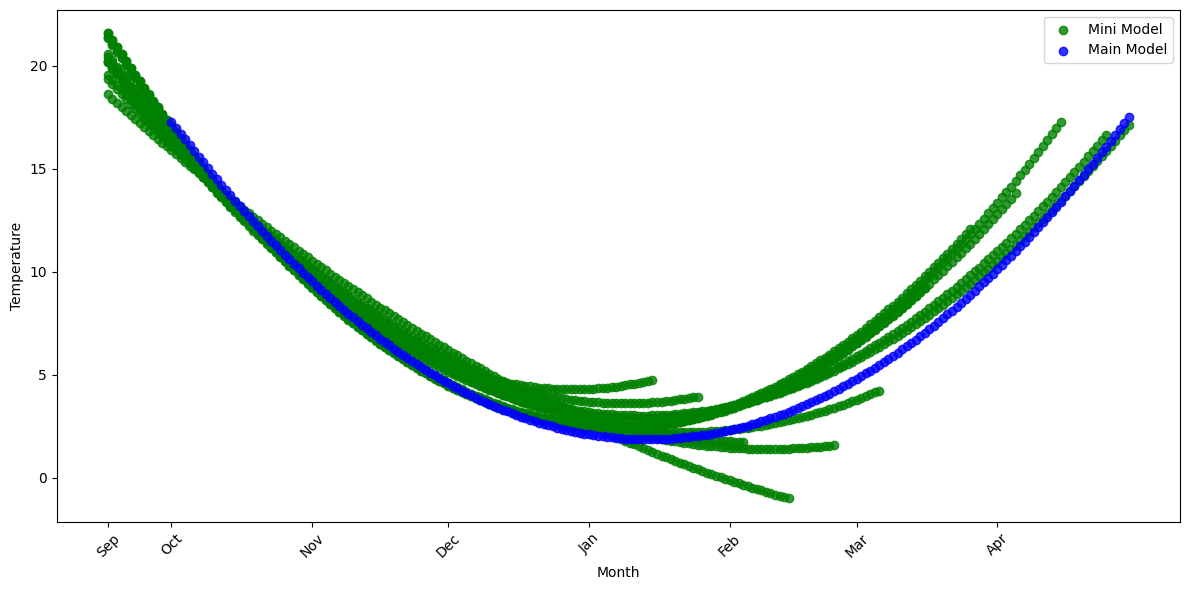

In [15]:
plt_models = PlotModels(main_model=main_Model, mini_models=models_more)



plt_models.plot_models()
# plt_models.plot_main_model()
# print(plt_models.tick_indices)
# print(plt_models.main_Model.x_plot_labels)
# print(plt_models.mini_Models.models[-1].x_plot_labels)
# print(plt_models.mini_Models.models[-1].raw_data)
# print(plt_models.x_plot_labels)

In [200]:
print(plt_models.mini_Models.starting_difference)
# print(plt_models.x_plot_labels[plt_models.mini_Models.starting_difference - 1:])
print(plt_models.x_plot_labels)

15
['09-16', '09-17', '09-18', '09-19', '09-20', '09-21', '09-22', '09-23', '09-24', '09-25', '09-26', '09-27', '09-28', '09-29', '09-30', '10-01', '10-02', '10-03', '10-04', '10-05', '10-06', '10-07', '10-08', '10-09', '10-10', '10-11', '10-12', '10-13', '10-14', '10-15', '10-16', '10-17', '10-18', '10-19', '10-20', '10-21', '10-22', '10-23', '10-24', '10-25', '10-26', '10-27', '10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11', '11-12', '11-13', '11-14', '11-15', '11-16', '11-17', '11-18', '11-19', '11-20', '11-21', '11-22', '11-23', '11-24', '11-25', '11-26', '11-27', '11-28', '11-29', '11-30', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09', '12-10', '12-11', '12-12', '12-13', '12-14', '12-15', '12-16', '12-17', '12-18', '12-19', '12-20', '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27', '12-28', '12-29', '12-30', '12-31', '01-01', '01-02', '01-03', '01-04

['10-01', '10-02', '10-03', '10-04', '10-05', '10-06', '10-07', '10-08', '10-09', '10-10', '10-11', '10-12', '10-13', '10-14', '10-15', '10-16', '10-17', '10-18', '10-19', '10-20', '10-21', '10-22', '10-23', '10-24', '10-25', '10-26', '10-27', '10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11', '11-12', '11-13', '11-14', '11-15', '11-16', '11-17', '11-18', '11-19', '11-20', '11-21', '11-22', '11-23', '11-24', '11-25', '11-26', '11-27', '11-28', '11-29', '11-30', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09', '12-10', '12-11', '12-12', '12-13', '12-14', '12-15', '12-16', '12-17', '12-18', '12-19', '12-20', '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27', '12-28', '12-29', '12-30', '12-31', '01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08', '01-09', '01-10', '01-11', '01-12', '01-13', '01-14', '01-15', '01-16', '01-17', '01-18', '01-19', 

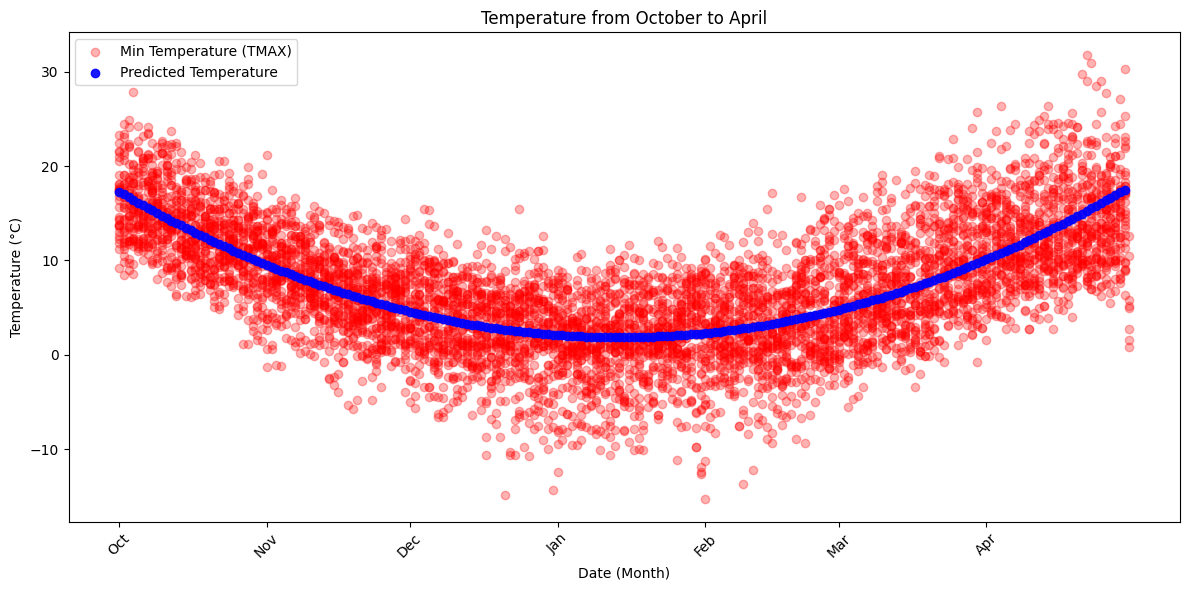

In [51]:
def compute_and_plot(model, x_plot_labels, color, alpha=0.5):
    x_labels_subset = x_plot_labels[:len(model.temp_pred)]

    plt.scatter(x_labels_subset, model.temp_pred, color=color, alpha=alpha, label="Predicted Temperature")


def plot_main_model(model):
    x_plot_labels = [f"{int(m):02d}-{int(d):02d}" for m, d in [(get_month_day(model.raw_data, round(i) - 1)) for i in model.X[:, 0]]]
    months = ['10-01', '11-01', '12-01', '01-01', '02-01', '03-01', '04-01']
    month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
    tick_indices = [i for i, label in enumerate(x_plot_labels) if label in months]
    plt.figure(figsize=(12, 6))

    print(x_plot_labels)

    df_filtered_later = get_data(1950, 1980)
    plt.scatter(df_filtered_later['MONTH_DAY'], df_filtered_later['TMAX'], color='red', alpha=0.3, label='Min Temperature (TMAX)')
    compute_and_plot(model, x_plot_labels, 'blue', alpha=0.9)

    plt.xlabel("Date (Month)")
    plt.ylabel("Temperature (°C)")
    plt.title("Temperature from October to April")
    plt.legend()

    plt.xticks([x_plot_labels[i] for i in tick_indices], month_labels)

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_main_model(main_Model)


In [30]:
plt_models.months_labels

['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']